In [1]:
import yfinance as yf
import numpy as np
import pandas as pd


stock_data=yf.Ticker('^GSPC').history(period="max")
stock_data.dropna(inplace=True)

In [2]:
period=20
stdev=2

stock_data['rolling_mean']=stock_data['Close'].rolling(window=period).mean()
stock_data['rolling_std']=stock_data['Close'].rolling(window=period).std()

datelims=['2022-01-01','2023-12-31']
_stock_data=stock_data.loc[datelims[0]:datelims[1]]
percent_bandwidth=(_stock_data['Close']-(_stock_data['rolling_mean']-2*_stock_data['rolling_std']))/((_stock_data['rolling_mean']+2*_stock_data['rolling_std'])-(_stock_data['rolling_mean']-2*_stock_data['rolling_std']))

bandwidth=((_stock_data['rolling_mean']+2*_stock_data['rolling_std'])-(_stock_data['rolling_mean']-2*_stock_data['rolling_std']))/_stock_data['rolling_mean']


In [3]:
sort_by = 'returns' # or by 'hit_rate'

results = []
bandwidths=np.linspace(0,1,40)
for first_limit in bandwidths:
    for second_limit in bandwidths:
        bb_signals = pd.DataFrame(index=_stock_data.index)
        bb_signals['Close'] = _stock_data['Close']
        bb_signals['signal'] = None

        bb_signals.loc[percent_bandwidth < first_limit, 'signal'] = 'buy'
        bb_signals.loc[percent_bandwidth > second_limit, 'signal'] = 'sell'

        bb_signals = bb_signals[bb_signals['signal'].notna()]
        bb_signals = bb_signals[bb_signals.signal.ne(bb_signals.signal.shift())]

        first_buy = bb_signals.loc[bb_signals.signal == 'buy'].index.min()
        last_sell = bb_signals.loc[bb_signals.signal == 'sell'].index.max()
        bb_signals = bb_signals[(bb_signals.index >= first_buy) & (bb_signals.index <= last_sell)]

        bb_signals['returns'] = bb_signals['Close'].pct_change()
        strategy_returns = bb_signals[bb_signals['signal']=='sell']['returns']
        cumulative_return = (1 + strategy_returns).prod() - 1
        
        results.append({
            'first_limit': first_limit,
            'second_limit': second_limit,
            'returns': cumulative_return,
            'hit_rate': len(bb_signals[bb_signals['returns'] > 0]) / len(bb_signals),
            'number_of_trades': len(bb_signals),
            'signals': bb_signals
        })

# Find best strategy
best_strategy = max(results, key=lambda x: x[sort_by])
print(f"Best strategy: Buy at {best_strategy['first_limit']}, Sell at {best_strategy['second_limit']}")
print(f"Total Return: {best_strategy['returns']:.2%}")

Best strategy: Buy at 0.0, Sell at 0.41025641025641024
Total Return: 27.00%


Number of trades: 24
Hit rate: 100.00%
Total time: 651 days 23:00:00


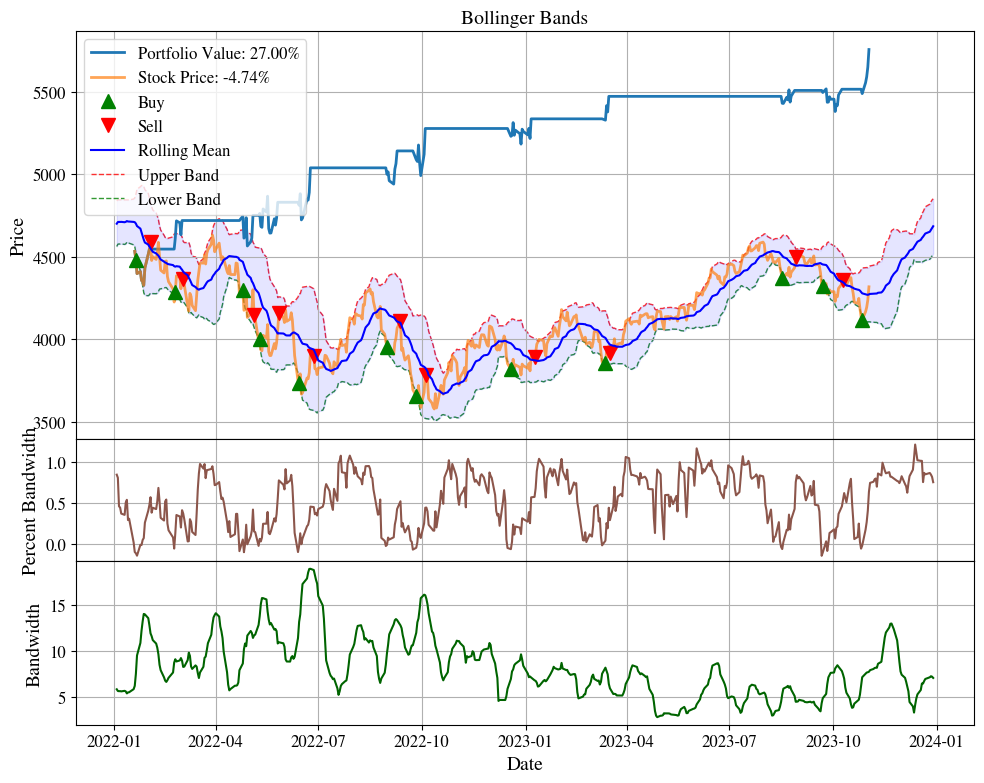

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from backtesting import Backtest

windows=[best_strategy['first_limit'],best_strategy['second_limit']]


#_stock_data=stock_data.copy()

bb_signals = pd.DataFrame(index=_stock_data.index)
bb_signals['Close'] = _stock_data['Close']
bb_signals['signal'] = None

buy_mask = percent_bandwidth < windows[0]
sell_mask = percent_bandwidth > windows[1]
bb_signals.loc[buy_mask.index[buy_mask], 'signal'] = 'buy'
bb_signals.loc[sell_mask.index[sell_mask], 'signal'] = 'sell'

backtester = Backtest(bb_signals,_stock_data)
backtester.run_backtest()

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



fig = plt.figure(figsize=(10, 8))

gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[1, 0.3, 0.4], hspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)


#ax1.plot(_stock_data['Close'],label='Close Price',color='black',zorder=5)
ax1=backtester.plot_strategy(tikr='SP500', ax=ax1)
ax1.plot(_stock_data['rolling_mean'],label='Rolling Mean',color='blue',zorder=2)
ax1.plot(_stock_data['rolling_mean']+stdev*_stock_data['rolling_std'],label='Upper Band',color='red',linestyle='--',linewidth=1,alpha=.8,zorder=0)
ax1.plot(_stock_data['rolling_mean']-stdev*_stock_data['rolling_std'],label='Lower Band',color='green',linestyle='--',linewidth=1,alpha=.8,zorder=0)
ax1.fill_between(_stock_data.index,_stock_data['rolling_mean']+stdev*_stock_data['rolling_std'],_stock_data['rolling_mean']-stdev*_stock_data['rolling_std'],color='blue',alpha=.1)
ax3.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid()
ax1.legend()
ax1.set_title('Bollinger Bands')


ax2.plot(percent_bandwidth,label='Percent Bandwidth',color='tab:brown',zorder=5)
ax2.set_ylabel('Percent Bandwidth')
ax2.grid()
#ax2.legend()

ax3.plot(bandwidth*100,label='Bandwidth',color='darkgreen',zorder=2)
ax3.set_ylabel('Bandwidth')
ax3.grid()
#ax3.legend()

plt.tight_layout()
plt.savefig('figures/bollinger_bands.png',dpi=300,bbox_inches='tight')
plt.show()

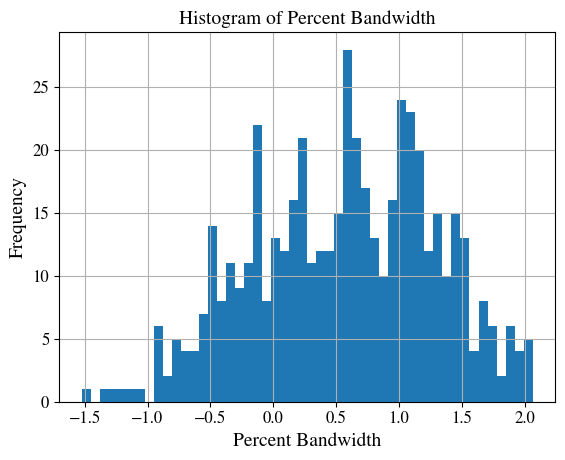

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
keltner_period=10
stock_data['typical_price']=(stock_data['High']+stock_data['Low']+stock_data['Close'])/3
stock_data['keltner_channel_center']=stock_data['typical_price'].rolling(window=keltner_period).mean()
stock_data['range']=stock_data['High']-stock_data['Low']
stock_data['keltner_channel_width']=stock_data['range'].rolling(window=keltner_period).mean()

datelims=['2022-01-01','2023-12-31']
_stock_data=stock_data.loc[datelims[0]:datelims[1]]

percent_bandwidth_keltner=(_stock_data['Close']-(_stock_data['keltner_channel_center']-_stock_data['keltner_channel_width']))/(2*_stock_data['keltner_channel_width'])

plt.hist(percent_bandwidth_keltner,bins=50)
plt.xlabel('Percent Bandwidth')
plt.ylabel('Frequency')
plt.title('Histogram of Percent Bandwidth')
plt.grid()
plt.show()

In [9]:
# Create signals based on percent_bandwidth_keltner thresholds
sort_by = 'returns' # or by 'hit_rate'

keltner_signals = pd.DataFrame(index=_stock_data.index)

keltner_bandwidths=np.linspace(-1,2,60)
results = []
for first_limit in keltner_bandwidths:
    for second_limit in keltner_bandwidths:
        keltner_signals = pd.DataFrame(index=_stock_data.index)
        keltner_signals['Close'] = _stock_data['Close']
        keltner_signals['signal'] = None

        keltner_signals.loc[percent_bandwidth_keltner < first_limit, 'signal'] = 'buy'
        keltner_signals.loc[percent_bandwidth_keltner > second_limit, 'signal'] = 'sell'

        keltner_signals = keltner_signals[keltner_signals['signal'].notna()]
        keltner_signals = keltner_signals[keltner_signals.signal.ne(keltner_signals.signal.shift())]

        first_buy = keltner_signals.loc[keltner_signals.signal == 'buy'].index.min()
        last_sell = keltner_signals.loc[keltner_signals.signal == 'sell'].index.max()
        keltner_signals = keltner_signals[(keltner_signals.index >= first_buy) & (keltner_signals.index <= last_sell)]

        keltner_signals['returns'] = keltner_signals['Close'].pct_change()
        strategy_returns = keltner_signals[keltner_signals['signal']=='sell']['returns']
        cumulative_return = (1 + strategy_returns).prod() - 1
        

        results.append({
            'first_limit': first_limit,
            'second_limit': second_limit,
            'returns': cumulative_return,
            'hit_rate': len(keltner_signals[keltner_signals['returns'] > 0]) / len(keltner_signals),
            'number_of_trades': len(keltner_signals),
            #'signals': keltner_signals
        })

# Find best strategy
best_strategy = max(results, key=lambda x: x[sort_by])
print(f"Best strategy: Buy at {best_strategy['first_limit']}, Sell at {best_strategy['second_limit']}")

print(f"Total Return: {best_strategy['returns']:.2%}")


Best strategy: Buy at -0.8983050847457628, Sell at 1.6949152542372885
Total Return: 29.19%


Number of trades: 8
Hit rate: 100.00%
Total time: 650 days 23:00:00


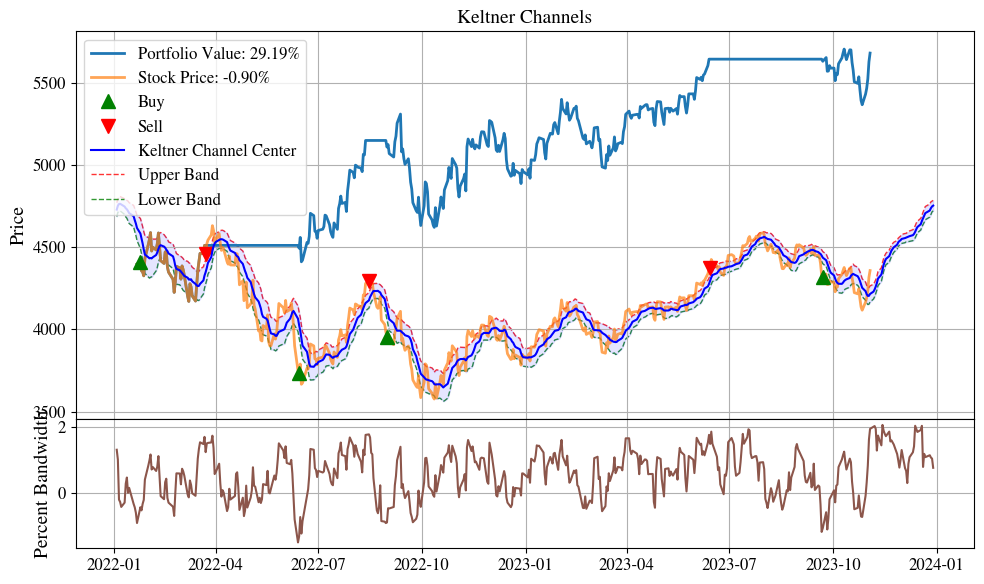

In [12]:

# Buy when close price crosses above upper band
# Sell when close price crosses below lower band

sell_signals = _stock_data[percent_bandwidth_keltner > best_strategy['second_limit']]
buy_signals = _stock_data[percent_bandwidth_keltner < best_strategy['first_limit']]

keltner_signals = _stock_data.copy()

keltner_signals['signal'] = None
keltner_signals.loc[sell_signals.index, 'signal'] = 'sell'
keltner_signals.loc[buy_signals.index, 'signal'] = 'buy'

backtester = Backtest(keltner_signals,_stock_data)
backtester.run_backtest()

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

ax2.plot(percent_bandwidth_keltner, label='Percent Bandwidth', color='tab:brown', zorder=5)
ax2.set_ylabel('Percent Bandwidth')
ax2.grid()
#ax2.legend()

#ax1.plot(_stock_data['Close'],label='Close Price',color='black',zorder=5)

ax1=backtester.plot_strategy(tikr='SP500', ax=ax1)
ax1.plot(_stock_data['keltner_channel_center'],label='Keltner Channel Center',color='blue',zorder=2)
ax1.plot(_stock_data['keltner_channel_center']+_stock_data['keltner_channel_width'],label='Upper Band',color='red',linestyle='--',linewidth=1,alpha=.8,zorder=0)
ax1.plot(_stock_data['keltner_channel_center']-_stock_data['keltner_channel_width'],label='Lower Band',color='green',linestyle='--',linewidth=1,alpha=.8,zorder=0)
ax1.fill_between(_stock_data.index,_stock_data['keltner_channel_center']+_stock_data['keltner_channel_width'],_stock_data['keltner_channel_center']-_stock_data['keltner_channel_width'],color='blue',alpha=.1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid()
ax1.legend()
ax1.set_title('Keltner Channels')
plt.tight_layout()
plt.savefig('figures/keltner_channels.png',dpi=300,bbox_inches='tight')
plt.show()